In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt


#tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = [x_train.reshape(60000, 784).astype('float32') / 255]
x_test = x_test.reshape(10000, 784).astype('float32') / 255

# Weights

In [3]:
weights = {
    # 5x5 conv, 1 input, 6 outputs
    'weights_conv_1': tf.Variable(tf.random.normal([5, 5, 1, 6])),
    # 5x5 conv, 6 inputs, 16 outputs
    'weights_conv_2': tf.Variable(tf.random.normal([5, 5, 6, 16])),
    #5x5 conv as in paper, 16 inputs, 120 outputs
    'weights_conv_3': tf.Variable(tf.random.normal([5, 5, 16, 120])),
    # fully connected, 5*5*16 inputs, 120 outputs
    'weights_dense_1': tf.Variable(tf.random.normal([5*5*16, 120])),
    # fully connected, 120 inputs, 84 outputs
    'weights_dense_2': tf.Variable(tf.random.normal([120, 84])),
    # 84 inputs, 10 outputs (class prediction)
    'weights_dense_3': tf.Variable(tf.random.normal([84, 10])),
}

biases = {
    #output depth
    'bias_conv_1': tf.Variable(tf.random.normal([6])),
    'bias_conv_2': tf.Variable(tf.random.normal([16])),
    'bias_dense_1': tf.Variable(tf.random.normal([120])),
    'bias_dense_2': tf.Variable(tf.random.normal([84])),
    'bias_dense_3': tf.Variable(tf.random.normal([10])),
}



# Wrappers

In [4]:
#conv2D with bias and relu activation

class CustomConvLayer(layers.Layer):

    def __init__(self, weights, biases, strides, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = weights
        self.b = biases
        self.s = strides
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, self.w, strides=[1, self.s, self.s, 1], padding=self.p)
        x = tf.nn.bias_add(x, self.b)
        return tf.nn.tanh(x)
        

#Average Pooling Layer
class CustomPoolLayer(layers.Layer):
    
    def __init__(self, k=2, padding='VALID'):
        super(CustomPoolLayer, self).__init__()
        self.k = k
        self.p = padding
    
    def call(self, inputs):
        return tf.nn.avg_pool2d(inputs, ksize=[1, self.k, self.k,1], strides=[1, self.k, self.k, 1], padding=self.p)

    
#Dense Layer with Bias
class CustomDenseLayer(layers.Layer):
    
    def __init__(self, weights, bias, activation = 'tanh'):
        super(CustomDenseLayer, self).__init__()
        self.w = weights
        self.b = bias
        self.a = activation
        
    def call(self, inputs):
        #print(self.w)
        #print(inputs)
        x = tf.matmul(inputs, self.w)
        #print(x)
        x = tf.nn.bias_add(x, self.b)
        if self.a == 'tanh':
            return tf.nn.tanh(x)
        if self.a == 'softmax':
            return tf.nn.softmax(x)


# Create Model

In [5]:
class CustomConvModel(tf.keras.Model):
    def __init__(self):
        super(CustomConvModel, self).__init__()
        self.conv1 = CustomConvLayer(weights['weights_conv_1'], biases['bias_conv_1'], 1, 'SAME')#'VALID')
        self.maxpool1 = CustomPoolLayer(k=2, padding='SAME')
        self.conv2 = CustomConvLayer(weights['weights_conv_2'], biases['bias_conv_2'], 1, 'VALID')
        self.maxpool2 = CustomPoolLayer(k=2, padding='VALID')
        self.conv3 = CustomConvLayer(weights['weights_conv_3'], biases['bias_dense_1'], 1, 'VALID')
        #self.dense1 = CustomDenseLayer(weights['weights_dense_1'], biases['bias_dense_1'], 'tanh')
        self.dense2 = CustomDenseLayer(weights['weights_dense_2'], biases['bias_dense_2'], 'tanh')
        self.dense3 = CustomDenseLayer(weights['weights_dense_3'], biases['bias_dense_3'], 'softmax')
        
    def call(self, inputs):
        x = tf.reshape(inputs, shape=[-1, 28, 28, 1])
        print(x.shape)
        x = self.conv1(x)
        print(x.shape)
        x = self.maxpool1(x)
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = self.maxpool2(x)
        #print('yo',x.shape)
        #x = layers.Flatten()(x)
        print(x.shape)
        x = self.conv3(x)
        print(x.shape)
        x = layers.Flatten()(x)
        print(x.shape)
        x =  self.dense2(x)
        print(x.shape)
        x =  self.dense3(x)
        print(x.shape)
        return x
        

In [6]:
model = CustomConvModel()

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              experimental_run_tf_function=False
             )

In [8]:
model.fit(x=x_train,
          y=y_train,
          batch_size=64,
          epochs=10,
          validation_data=(x_test, y_test),
         )

(None, 28, 28, 1)
(None, 28, 28, 6)
(None, 14, 14, 6)
(None, 10, 10, 16)
(None, 5, 5, 16)
(None, 1, 1, 120)
(None, 120)
(None, 84)
(None, 10)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 288us/sample - loss: 2.0004 - accuracy: 0.4564 - val_loss: 1.8849 - val_accuracy: 0.5758
Epoch 2/10
60000/60000 [==============================] - 16s 271us/sample - loss: 1.8604 - accuracy: 0.5989 - val_loss: 1.8397 - val_accuracy: 0.6198
Epoch 3/10
60000/60000 [==============================] - 15s 252us/sample - loss: 1.8314 - accuracy: 0.6280 - val_loss: 1.8180 - val_accuracy: 0.6425
Epoch 4/10
60000/60000 [==============================] - 15s 255us/sample - loss: 1.8192 - accuracy: 0.6405 - val_loss: 1.8152 - val_accuracy: 0.6451
Epoch 5/10
60000/60000 [==============================] - 17s 288us/sample - loss: 1.8112 - accuracy: 0.6484 - val_loss: 1.8049 - val_accuracy: 0.6549
Epoch 6/10
60000/60000 [=============================

In [11]:
keras_model = tf.keras.Sequential()
keras_model.add(layers.Reshape((28, 28,1)))
#differences convolutional layer: 
#keras.layers.Conv2D uses 'glorot_uniform' initializer
#keras.layers.Conv2D uses padding method 'valid' as default
keras_model.add(layers.Conv2D(filters=6, kernel_size=(5,5), activation='tanh', padding='SAME',input_shape=(28,28,1)))
#differences pooling layer: 
#keras.layers.AvgPooling2D uses padding method 'valid' (vs. 'SAME' in custom) as default
keras_model.add(layers.AvgPool2D(padding='SAME'))
keras_model.add(layers.Conv2D(filters=16, kernel_size=(5,5), activation='tanh'))
keras_model.add(layers.AvgPool2D())
keras_model.add(layers.Flatten())
keras_model.add(layers.Dense(120, activation='tanh'))
keras_model.add(layers.Dense(84, activation='tanh'))
keras_model.add(layers.Dense(10, activation='softmax'))

In [12]:
keras_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                    metrics=['accuracy'],
                    experimental_run_tf_function=False
                   )

In [13]:
keras_model.fit(x=x_train,
                y=y_train,
                batch_size=64,
                epochs=2,
                validation_data=(x_test, y_test),
         )

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 74s 1ms/sample - loss: 1.5745 - accuracy: 0.9003 - val_loss: 1.5084 - val_accuracy: 0.9577
Epoch 2/2
60000/60000 [==============================] - 65s 1ms/sample - loss: 1.5016 - accuracy: 0.9635 - val_loss: 1.5019 - val_accuracy: 0.9636


In [14]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  156       
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2416      
_________________________________________________________________
average_pooling2d_1 (Average multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  4

In [10]:
model.predict(x_test[:30])

array([[6.35625406e-12, 6.20581169e-13, 8.41046815e-25, 2.38803269e-19,
        1.40027533e-17, 3.86657338e-20, 9.72242780e-18, 1.00000000e+00,
        1.99408374e-13, 3.77477075e-13],
       [3.77606344e-03, 4.01094854e-01, 4.59477046e-16, 1.63717158e-17,
        5.91337326e-08, 7.55477538e-12, 4.32101637e-01, 3.84465864e-08,
        1.63027346e-01, 1.68447634e-09],
       [8.96663370e-18, 9.99999881e-01, 6.93186090e-19, 6.18410483e-17,
        6.55287167e-08, 1.15881764e-14, 4.43668817e-11, 1.26690827e-08,
        5.57403733e-13, 1.86160657e-13],
       [1.00000000e+00, 9.12209949e-17, 4.11805966e-23, 2.51894551e-21,
        1.14765705e-14, 8.38130207e-15, 4.21458493e-11, 1.40661580e-11,
        1.89742771e-15, 5.97348017e-13],
       [2.69392294e-17, 6.44719762e-08, 4.00727415e-19, 2.62377587e-20,
        9.99994516e-01, 6.64652195e-17, 3.16971005e-13, 9.48840508e-08,
        4.65597765e-17, 5.33139882e-06],
       [3.12816234e-15, 1.00000000e+00, 1.80921076e-17, 1.24080840e-15,
   

In [15]:
preds = map (lambda pred: np.argmax(pred), model.predict(x_test[:30]))
preds = list(preds)

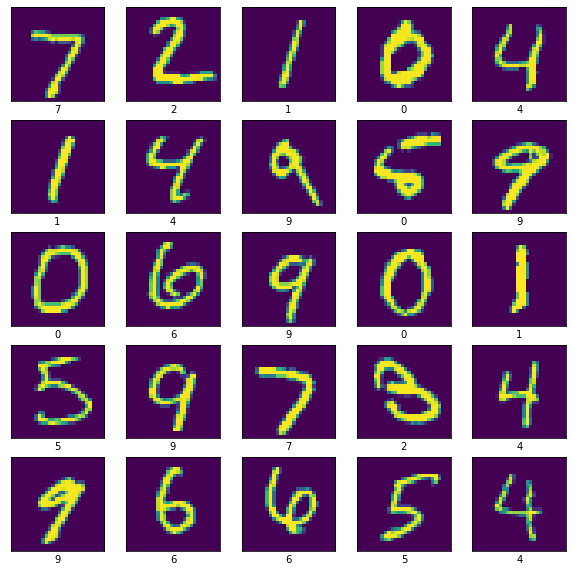

In [16]:


plt.figure(figsize=(10,10))
for i in range(25):
    img = tf.reshape(x_test[i], shape=[28, 28])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)

    plt.xlabel(preds[i])
plt.show()